<a href="https://colab.research.google.com/github/Chadamohith/Chemical-Hazardous-Prediction/blob/main/ap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install pandas pubchempy rdkit tqdm

import pandas as pd
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm
from google.colab import files


dataset_file = "chemical_dataset_100.csv"
df = pd.read_csv(dataset_file)
print("Original dataset shape:", df.shape)
print(df.head())


df.columns = df.columns.str.strip().str.replace('[^A-Za-z0-9_]+', '_', regex=True)


def fetch_bp_mp(name):
    try:
        compound = pcp.get_compounds(name, 'name')
        if len(compound) == 0:
            return None, None
        c = compound[0]
        bp = getattr(c, 'boiling_point', None)
        mp = getattr(c, 'melting_point', None)
        return bp, mp
    except:
        return None, None

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    if pd.isna(row['Boiling_Point_C_']) or pd.isna(row['Melting_Point_C_']):
        bp, mp = fetch_bp_mp(row['Name'])
        if pd.isna(row['Boiling_Point_C_']):
            df.at[idx, 'Boiling_Point_C_'] = bp
        if pd.isna(row['Melting_Point_C_']):
            df.at[idx, 'Melting_Point_C_'] = mp

# Step 4: Add features from SMILES using RDKit
def smiles_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        heavy_atoms = Descriptors.HeavyAtomCount(mol)
        rings = Descriptors.RingCount(mol)
        return pd.Series([mw, logp, hbd, hba, heavy_atoms, rings])
    except:
        return pd.Series([None]*6)

df[['Molecular_Weight','LogP','H_Bond_Donors','H_Bond_Acceptors','Heavy_Atom_Count','Ring_Count']] = df['SMILES'].apply(smiles_features)


df_cleaned = df.dropna(subset=['SMILES','Boiling_Point_C_','Melting_Point_C_'])


output_file = '/content/cleaned_chemical_dataset100.csv'
df_cleaned.to_csv(output_file, index=False)
print("Cleaned dataset saved as:", output_file)


files.download(output_file)

Original dataset shape: (100, 6)
     ID             Name       SMILES  Boiling Point (°C)  Melting Point (°C)  \
0  C101    Sulfuric Acid  OS(=O)(=O)O               337.0                10.0   
1  C102  Sodium Chloride  [Na+].[Cl-]              1413.0               801.0   
2  C103          Benzene     c1ccccc1                80.1                 5.5   
3  C104          Ethanol          CCO                78.4              -114.0   
4  C105          Mercury         [Hg]               356.7               -38.8   

  Hazardous  
0       Yes  
1        No  
2       Yes  
3        No  
4       Yes  


100%|██████████| 100/100 [00:00<00:00, 148.02it/s]

Cleaned dataset saved as: /content/cleaned_chemical_dataset100.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install pandas rdkit tqdm pubchempy seaborn matplotlib


Dataset loaded: (98, 12)
Feature extraction complete! File saved as: /content/chemical_features_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

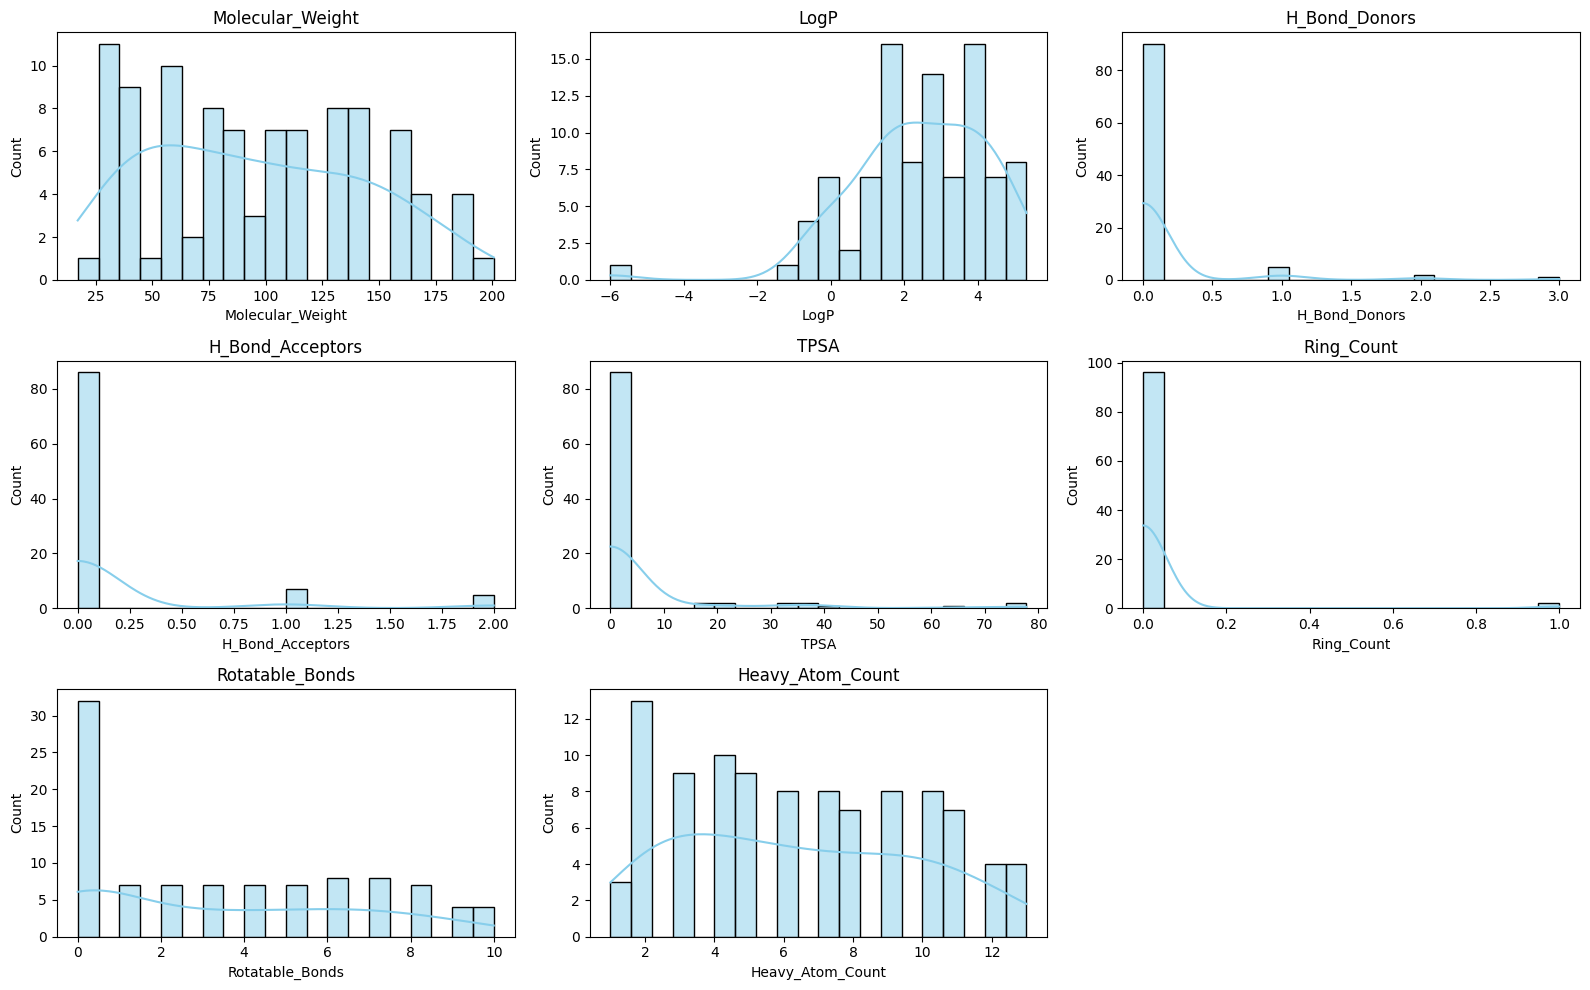

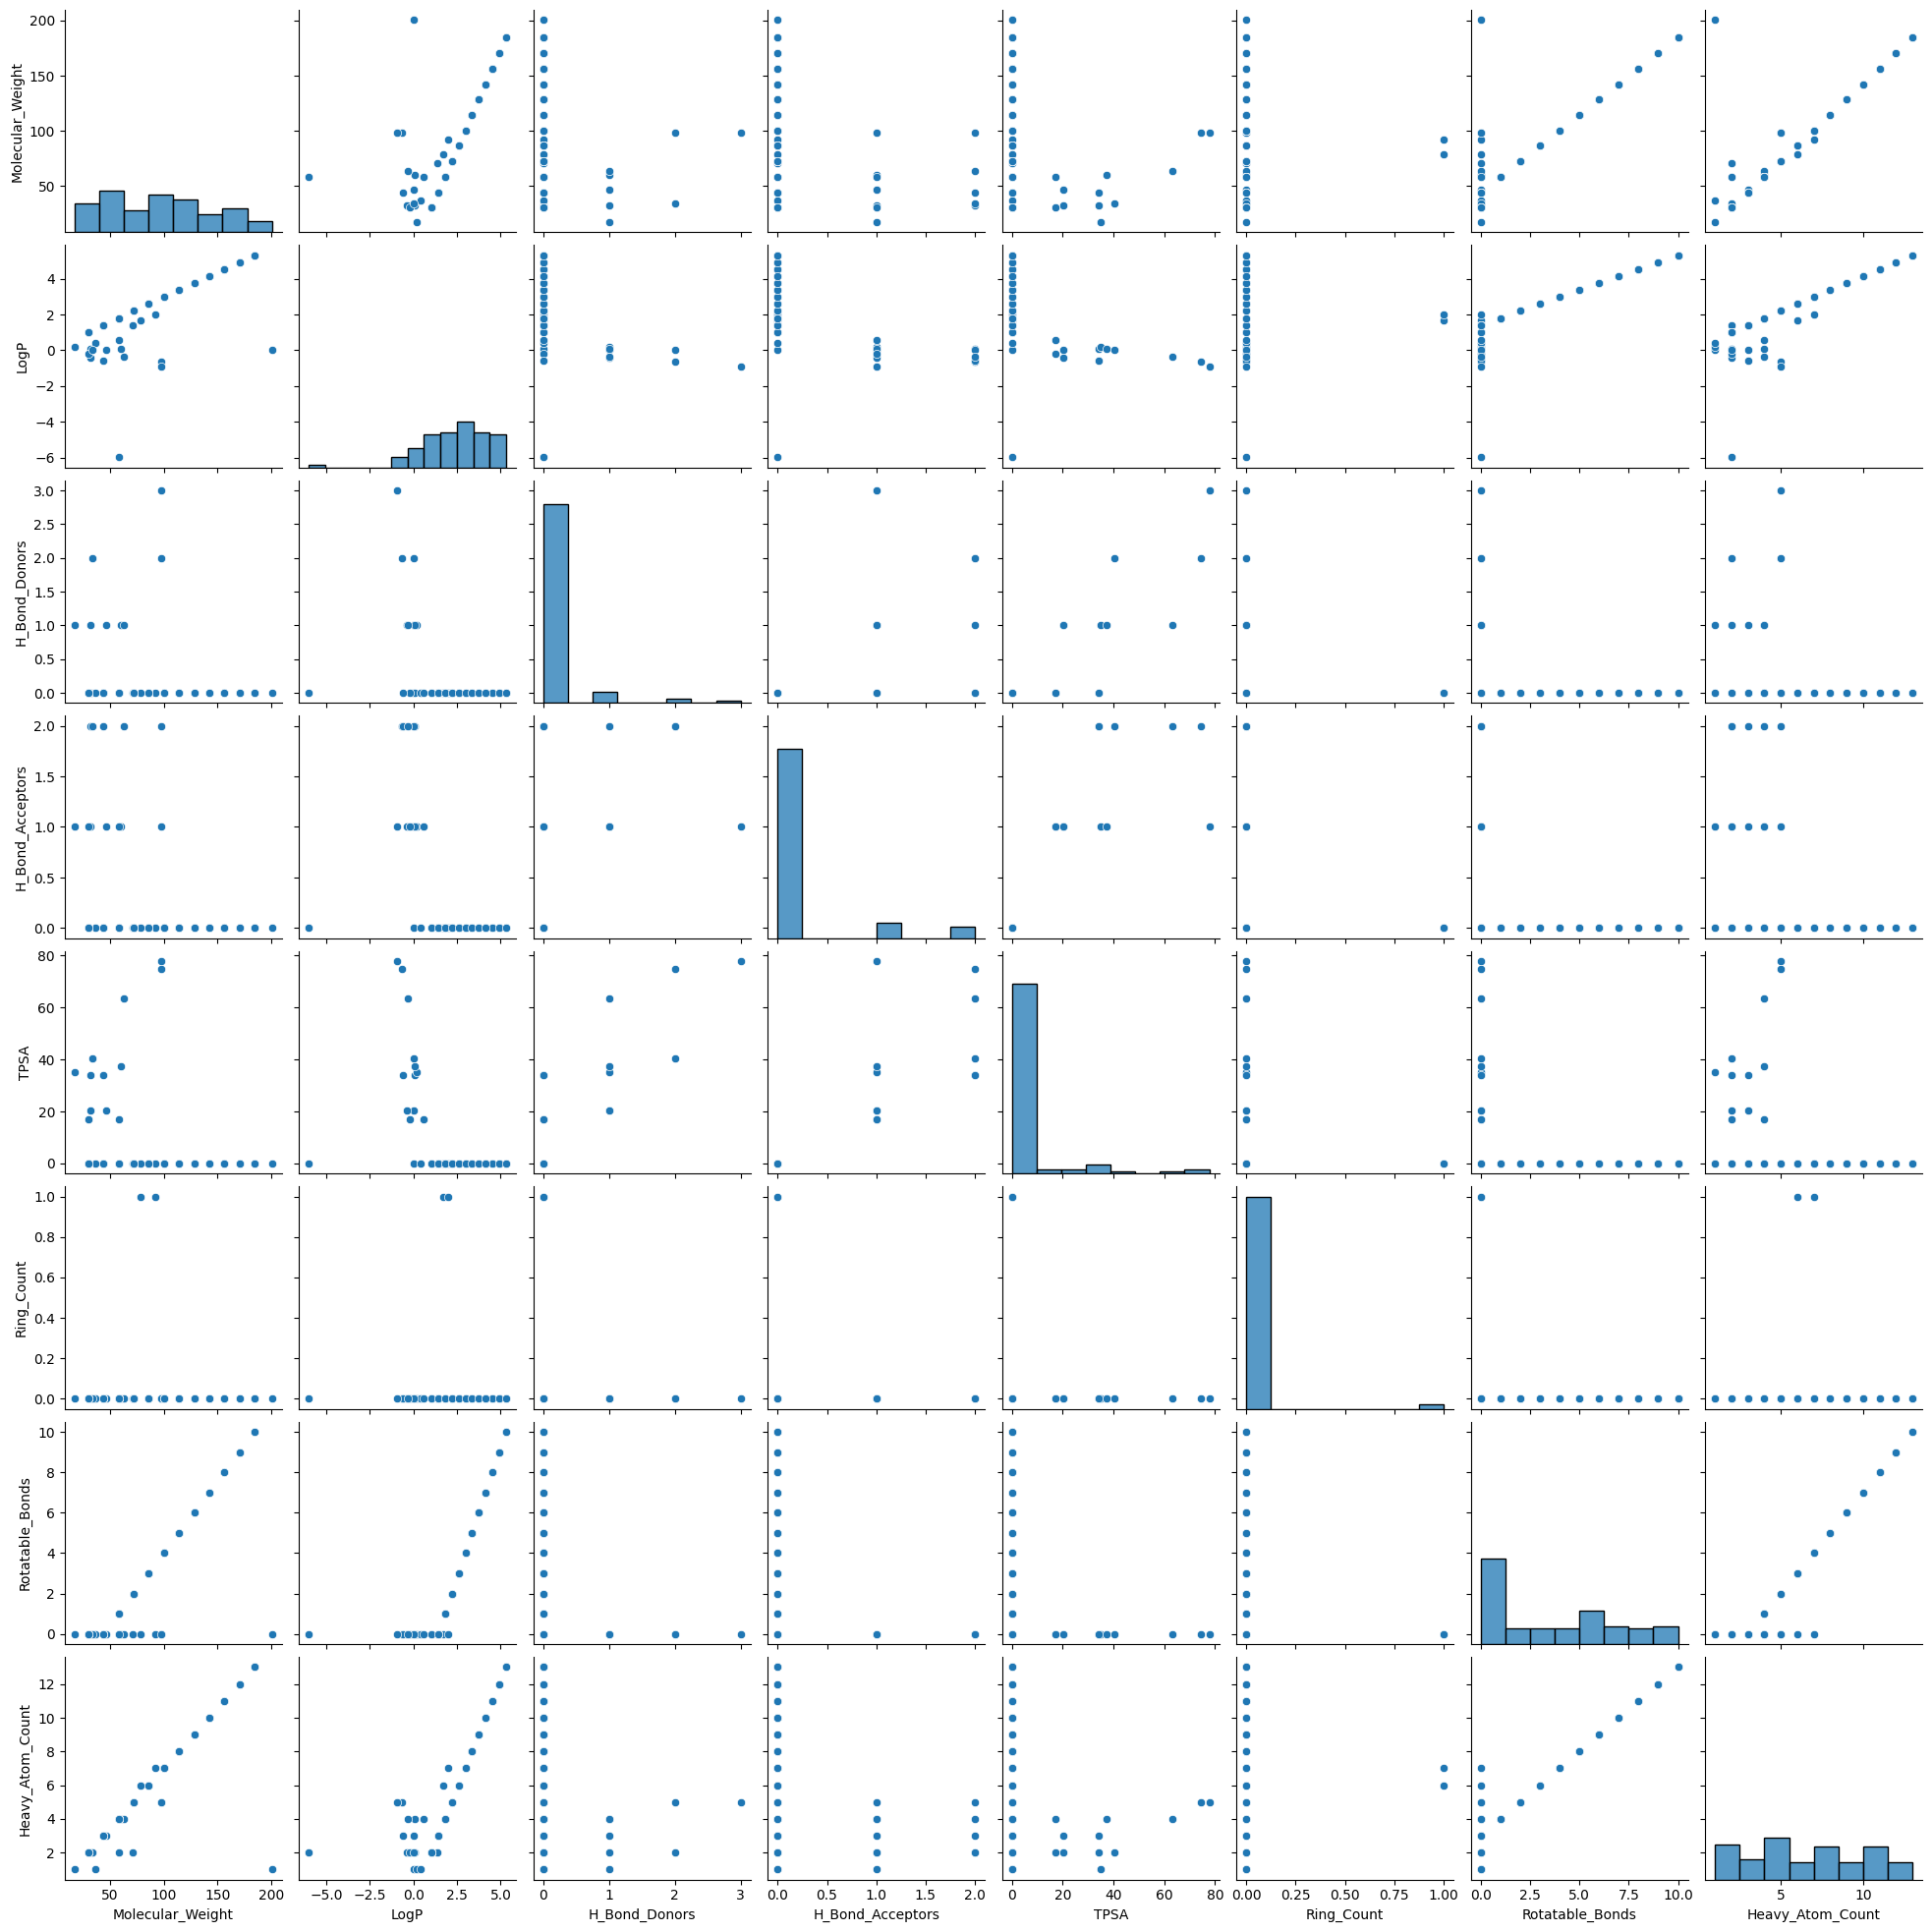

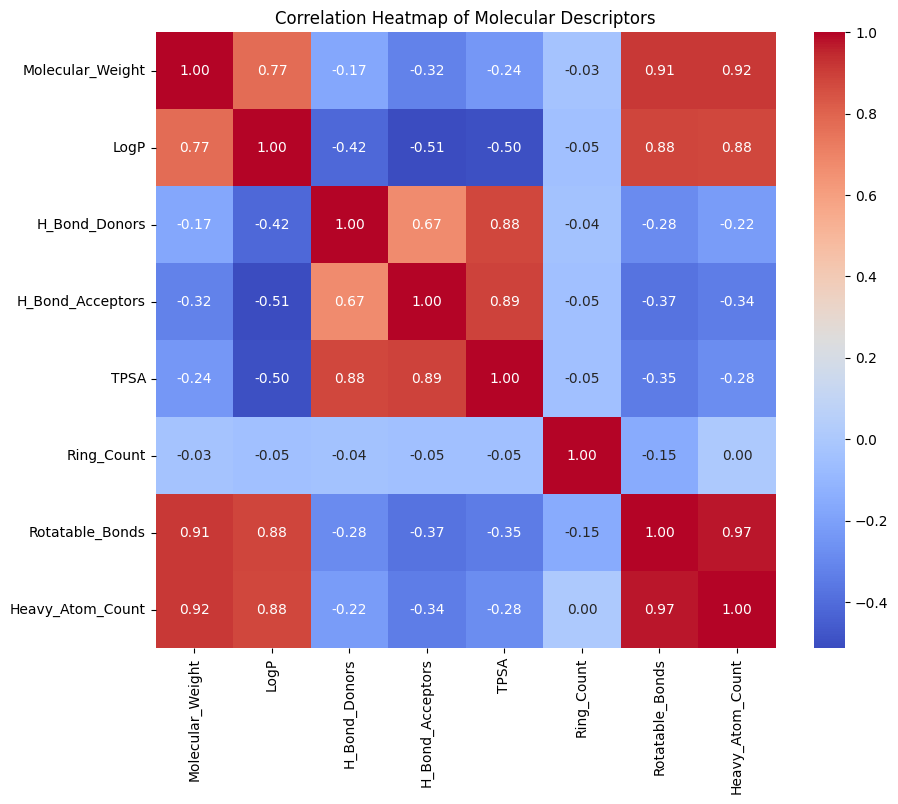

/tmp/ipython-input-1445372947.py:94: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=final_df, x=col, hue="Hazardous", fill=True)


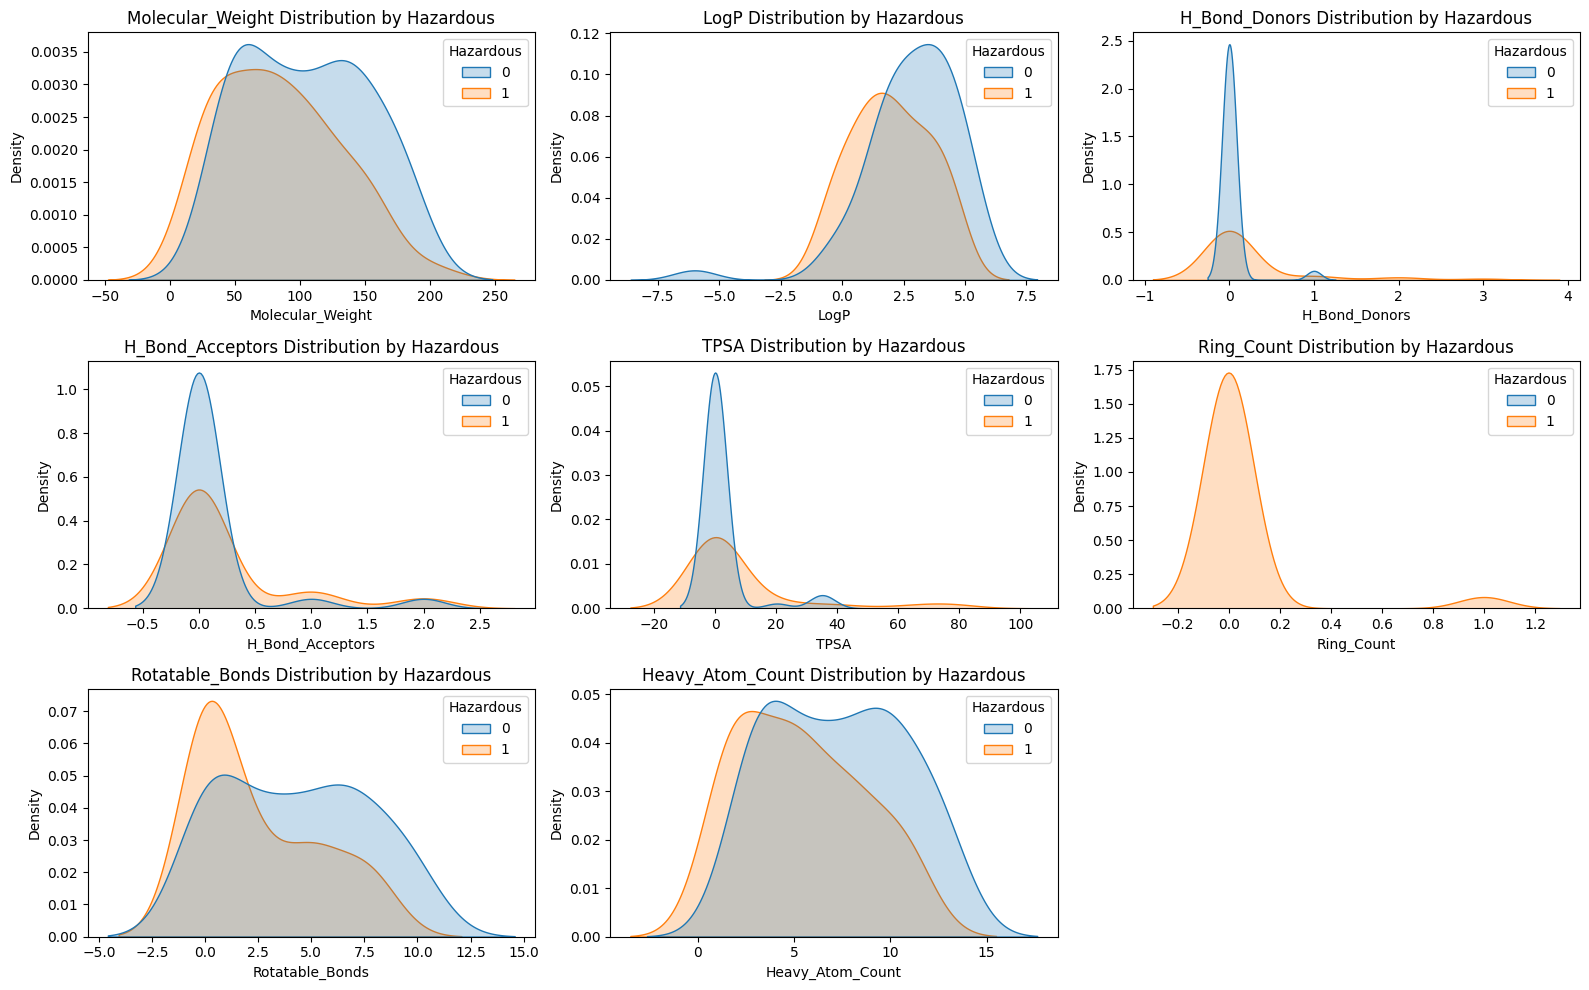

In [ ]:

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from tqdm import tqdm
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load dataset
dataset_file = "cleaned_chemical_dataset100.csv"  # Your cleaned dataset
df = pd.read_csv(dataset_file)
print("Dataset loaded:", df.shape)


df.columns = df.columns.str.strip().str.replace('[^A-Za-z0-9_]+', '_', regex=True)


df['Hazardous'] = df['Hazardous'].map({'Yes':1, 'No':0})

# Step 4: Extract molecular descriptors
def extract_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
             return pd.Series([None]*8)
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        tpsa = Descriptors.TPSA(mol)
        rings = Descriptors.RingCount(mol)
        rot_bonds = Descriptors.NumRotatableBonds(mol)
        heavy_atoms = Descriptors.HeavyAtomCount(mol)
        return pd.Series([mw, logp, hbd, hba, tpsa, rings, rot_bonds, heavy_atoms])
    except:
        return pd.Series([None]*8)

descriptor_cols = ['Molecular_Weight','LogP','H_Bond_Donors','H_Bond_Acceptors',
                   'TPSA','Ring_Count','Rotatable_Bonds','Heavy_Atom_Count']

df[descriptor_cols] = df['SMILES'].apply(extract_descriptors)

# Step 5: Extract fingerprints (optional)
def extract_fingerprint(smiles, nBits=1024):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [None]*nBits
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
        arr = [int(fp.GetBit(i)) for i in range(nBits)]
        return arr
    except:
        return [None]*nBits

fingerprint_df = df['SMILES'].apply(lambda x: pd.Series(extract_fingerprint(x)))
fingerprint_df.columns = [f'FP_{i}' for i in range(fingerprint_df.shape[1])]

# Step 6: Combine descriptors + fingerprints with original dataset
final_df = pd.concat([df, fingerprint_df], axis=1)

# Step 7: Save final feature dataset
output_file = '/content/chemical_features_dataset.csv'
final_df.to_csv(output_file, index=False)
print("Feature extraction complete! File saved as:", output_file)

# Step 8: Download the file
files.download(output_file)

# Step 9: Visualization of descriptors

# Histograms
plt.figure(figsize=(16,10))
for i, col in enumerate(descriptor_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(final_df[col].dropna(), kde=True, bins=20, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

# Pairplot
sns.pairplot(final_df[descriptor_cols].dropna())
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(final_df[descriptor_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Molecular Descriptors")
plt.show()

# Optional: Compare descriptors for Hazardous vs Non-Hazardous
plt.figure(figsize=(16,10))
for i, col in enumerate(descriptor_cols):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(data=final_df, x=col, hue="Hazardous", fill=True)
    plt.title(f"{col} Distribution by Hazardous")
plt.tight_layout()
plt.show()

✅ Dataset Loaded Successfully!
Shape: (98, 1038)
     ID             Name       SMILES  Boiling_Point_C_  Melting_Point_C_  \
0  C101    Sulfuric Acid  OS(=O)(=O)O             337.0              10.0   
1  C102  Sodium Chloride  [Na+].[Cl-]            1413.0             801.0   
2  C103          Benzene     c1ccccc1              80.1               5.5   

   Hazardous  Molecular_Weight    LogP  H_Bond_Donors  H_Bond_Acceptors  ...  \
0          1            98.079 -0.6528            2.0               2.0  ...   
1          0            58.443 -5.9920            0.0               0.0  ...   
2          1            78.114  1.6866            0.0               0.0  ...   

   FP_1014  FP_1015  FP_1016  FP_1017  FP_1018  FP_1019  FP_1020  FP_1021  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   

   FP_1022  

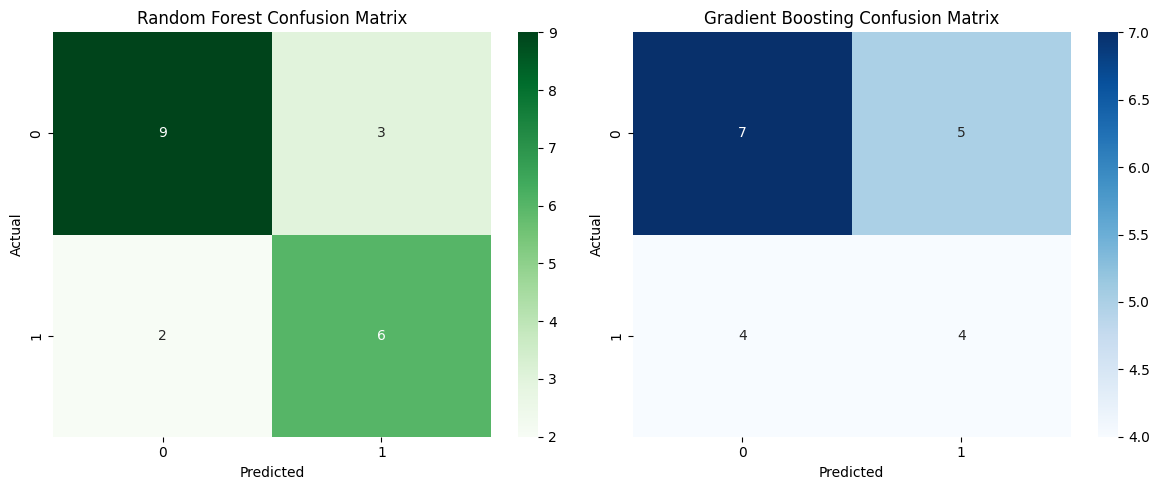


Detailed Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.67      0.75      0.71         8

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20


🔍 Example Predictions (First 10):
   Actual  RandomForest_Pred  GradientBoosting_Pred
0       1                  0                      0
1       0                  1                      1
2       0                  0                      0
3       0                  0                      0
4       0                  0                      0
5       1                  1                      1
6       0                  0                      0
7       0                  0                      1
8       1                  1                      1
9       1                  1                      1

💾 Model saved as

In [ ]:
# ===============================
# 📘 CELL 3: Model Training and Evaluation
# ===============================

# Import dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the final dataset
dataset_file = "chemical_features_dataset.csv"
df = pd.read_csv(dataset_file)
print("✅ Dataset Loaded Successfully!")
print("Shape:", df.shape)
print(df.head(3))

# Step 2: Separate features (X) and labels (y)
# We'll drop columns that are not numerical features (like Name, SMILES, or ID)
X = df.drop(columns=['ID', 'Name', 'SMILES', 'Hazardous'], errors='ignore')
y = df['Hazardous']

print("\n✅ Feature and Target Columns Separated:")
print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)

# Step 3: Handle any missing values
X = X.fillna(0)

# Step 4: Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\n✅ Data Split Completed:")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

# Step 5: Train Machine Learning Models

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test) # This should be X_test, not y_test

# Step 6: Evaluate Models
rf_acc = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
gb_acc = accuracy_score(y_test, gb_preds)
gb_f1 = f1_score(y_test, gb_preds)

print("\n📊 Model Evaluation Results:")
print(f"Random Forest - Accuracy: {rf_acc:.3f}, F1-Score: {rf_f1:.3f}")
print(f"Gradient Boosting - Accuracy: {gb_acc:.3f}, F1-Score: {gb_f1:.3f}")

# Step 7: Confusion Matrix Visualization
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, gb_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# Step 8: Display Classification Report
print("\nDetailed Classification Report (Random Forest):")
print(classification_report(y_test, rf_preds))

# Step 9: Example Predictions
sample_preds = pd.DataFrame({
    'Actual': y_test.values[:10],
    'RandomForest_Pred': rf_preds[:10],
    'GradientBoosting_Pred': gb_preds[:10]
})
print("\n🔍 Example Predictions (First 10):")
print(sample_preds)

# Step 10: Save the trained Random Forest model
import joblib
joblib.dump(rf_model, "/content/chemical_hazard_model.pkl")
print("\n💾 Model saved as chemical_hazard_model.pkl")

print("\n✅ Training & Evaluation Completed Successfully!")

In [ ]:
import pubchempy as pcp
from rdkit import Chem

def get_smiles_from_input(inp):
    # If it's already a SMILES, RDKit will parse it
    mol = Chem.MolFromSmiles(inp)
    if mol:
        return inp  # it's valid SMILES
    # Otherwise, try to get SMILES from PubChem by name
    try:
        comp = pcp.get_compounds(inp, 'name')
        if comp and comp[0].canonical_smiles:
            return comp[0].canonical_smiles
    except Exception:
        pass
    return None


In [ ]:
def get_smiles_from_input(inp):
    # Check if input is already a valid SMILES
    mol = Chem.MolFromSmiles(inp)
    if mol:
        return inp  # input is already a valid SMILES

    # Fetch SMILES from PubChem
    try:
        comp = pcp.get_compounds(inp, 'name')
        if comp:
            return comp[0].connectivity_smiles  # updated attribute
    except Exception as e:
        print("Error fetching from PubChem:", e)

    return None


In [ ]:
# ===========================================
# ✅ CHEMICAL HAZARD PREDICTION INPUT TEST
# ===========================================
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

# --- Function to generate same features used in training (1034 total) ---
def generate_features(smiles, nBits=1024):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"❌ Invalid SMILES string: {smiles}")
            return None

        # 8 descriptors (same as training)
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        tpsa = Descriptors.TPSA(mol)
        rings = Descriptors.RingCount(mol)
        rot_bonds = Descriptors.NumRotatableBonds(mol)
        heavy_atoms = Descriptors.HeavyAtomCount(mol)

        # Add placeholders for Boiling & Melting points (to make total 10 descriptors)
        boiling_point = 0
        melting_point = 0

        desc = [mw, logp, hbd, hba, tpsa, rings, rot_bonds, heavy_atoms,
                boiling_point, melting_point]  # 10 descriptors

        # Molecular fingerprint (1024 bits)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
        fp_arr = [int(fp.GetBit(i)) for i in range(nBits)]

        # Combine
        features = desc + fp_arr
        return np.array(features).reshape(1, -1)

    except Exception as e:
        print("Error generating features:", e)
        return None

# --- Get input from user ---
smiles_input = input("Enter one or more SMILES (comma-separated): ").strip()
smiles_list = [s.strip() for s in smiles_input.split(",") if s.strip()]

# --- Predict for each input ---
results = []

for smi in smiles_list:
    features = generate_features(smi)
    if features is not None:
        pred = model.predict(features)[0]
        label = "Hazardous" if pred == 1 else "Non-Hazardous"
        results.append({"SMILES": smi, "Prediction": label})
    else:
        results.append({"SMILES": smi, "Prediction": "Invalid"})

# --- Display output as a table ---
results_df = pd.DataFrame(results)
print("\n✅ Prediction Results:\n")
print(results_df.to_string(index=False))

Enter one or more SMILES (comma-separated): benzene
❌ Invalid SMILES string: benzene

✅ Prediction Results:

 SMILES Prediction
benzene    Invalid


In [ ]:
import sys, subprocess

# Pip installs
subprocess.check_call([sys.executable, "-m", "pip", "install",
                       "gradio", "scikit-learn", "pandas", "pubchempy", "tqdm"])

# Optional: apt-get install (works only on Ubuntu/Debian + root access)
# subprocess.check_call(["sudo", "apt-get", "install", "-y", "python3-rdkit", "librdkit1", "rdkit-data"])


0

In [ ]:
!pip install gradio scikit-learn pandas pubchempy tqdm
!apt-get install -y python3-rdkit librdkit1 rdkit-data


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
librdkit1 is already the newest version (202109.2-1build1).
python3-rdkit is already the newest version (202109.2-1build1).
rdkit-data is already the newest version (202109.2-1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
# ===========================================
# 🧪 PUBCHEM CHEMICAL HAZARD PREDICTION (Full 1034 Features)
# ===========================================

import pandas as pd
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib
import gradio as gr
import pubchempy as pcp

# -------------------------------
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# -------------------------------
# Define lists of compounds
hazardous_names = ["benzene", "formaldehyde", "toluene", "chloroform", "phenol", "acetone", "hydrogen cyanide"]
safe_names = ["glucose", "alanine", "ethanol", "water", "sucrose", "glycerol", "acetic acid"]

# -------------------------------
# Fetch SMILES from PubChem
def fetch_smiles(names):
    smiles_list = []
    for name in names:
        try:
            comp = pcp.get_compounds(name, 'name')
            if comp:
                smiles_list.append((name, comp[0].connectivity_smiles))
        except:
            smiles_list.append((name, None))
    return smiles_list

hazardous_smiles = fetch_smiles(hazardous_names)
safe_smiles = fetch_smiles(safe_names)

# -------------------------------
# Create DataFrame
hazardous_df = pd.DataFrame(hazardous_smiles, columns=["Name", "SMILES"])
hazardous_df["Label"] = 1

safe_df = pd.DataFrame(safe_smiles, columns=["Name", "SMILES"])
safe_df["Label"] = 0

data = pd.concat([hazardous_df, safe_df], ignore_index=True)
data.dropna(inplace=True)
print("✅ Dataset ready:\n", data)

# -------------------------------
# Feature generation (10 descriptors + 1024-bit Morgan fingerprint)
def generate_features(smiles, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # 10 descriptors
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    tpsa = Descriptors.TPSA(mol)
    rings = Descriptors.RingCount(mol)
    rot_bonds = Descriptors.NumRotatableBonds(mol)
    heavy_atoms = Descriptors.HeavyAtomCount(mol)
    boiling_point = 0
    melting_point = 0
    desc = [mw, logp, hbd, hba, tpsa, rings, rot_bonds, heavy_atoms, boiling_point, melting_point]

    # Morgan fingerprint
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
    fp_arr = [int(fp.GetBit(i)) for i in range(nBits)]

    features = desc + fp_arr
    return features

# -------------------------------
# Generate feature matrix
X = []
y = data['Label'].tolist()
for smi in data['SMILES']:
    feats = generate_features(smi)
    X.append(feats)

X = np.array(X)
y = np.array(y)

# -------------------------------
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Train RandomForestClassifier
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# -------------------------------
# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# -------------------------------
# Save model
joblib.dump(model, 'chemical_hazard_model_1034.pkl')
print("✅ Model saved as 'chemical_hazard_model_1034.pkl'")

# -------------------------------
# Helper: Convert name → SMILES
def get_smiles_safe(user_input):
    mol = Chem.MolFromSmiles(user_input)
    if mol:
        return user_input
    try:
        compounds = pcp.get_compounds(user_input, 'name')
        if compounds:
            return compounds[0].connectivity_smiles
    except Exception:
        pass
    return None

# -------------------------------
# Gradio prediction function
def predict_hazard(input_text):
    if not input_text.strip():
        return pd.DataFrame([["❌ Enter SMILES or compound names", "-", "-", "-", "-", "-"]],
                            columns=["Input", "Prediction", "MolWt", "LogP", "H-Donors", "H-Acceptors"])

    input_list = [s.strip() for s in input_text.split(",")]
    results = []

    for item in input_list:
        smiles = get_smiles_safe(item)
        if smiles is None:
            results.append([item, "Invalid name/SMILES", "-", "-", "-", "-"])
            continue

        features = generate_features(smiles)
        if features is not None:
            try:
                pred = model.predict([features])[0]
                label = "Hazardous" if pred == 1 else "Non-Hazardous"

                mol = Chem.MolFromSmiles(smiles)
                results.append([
                    item, label,
                    Descriptors.MolWt(mol),
                    Descriptors.MolLogP(mol),
                    Descriptors.NumHDonors(mol),
                    Descriptors.NumHAcceptors(mol)
                ])
            except Exception as e:
                results.append([item, f"Prediction error: {e}", "-", "-", "-", "-"])
        else:
            results.append([item, "Invalid SMILES", "-", "-", "-", "-"])

    return pd.DataFrame(results, columns=["Input", "Prediction", "MolWt", "LogP", "H-Donors", "H-Acceptors"])

# -------------------------------
# Launch Gradio interface
demo = gr.Interface(
    fn=predict_hazard,
    inputs=gr.Textbox(
        label="Enter one or more SMILES or compound names (comma-separated)",
        placeholder="Example: glucose, benzene, ethanol"
    ),
    outputs=gr.Dataframe(label="Prediction Results"),
    title="🧪 PubChem Chemical Hazard Prediction",
    description="Predicts if a chemical compound is Hazardous or Non-Hazardous using descriptors + fingerprints.",
    theme="soft"
)

demo.launch(share=True)


✅ Dataset ready:
                 Name                                         SMILES  Label
0            benzene                                    C1=CC=CC=C1      1
1       formaldehyde                                            C=O      1
2            toluene                                   CC1=CC=CC=C1      1
3         chloroform                                    C(Cl)(Cl)Cl      1
4             phenol                                 C1=CC=C(C=C1)O      1
5            acetone                                        CC(=O)C      1
6   hydrogen cyanide                                            C#N      1
7            glucose                       C(C1C(C(C(C(O1)O)O)O)O)O      0
8            alanine                                    CC(C(=O)O)N      0
9            ethanol                                            CCO      0
10             water                                              O      0
11           sucrose  C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O      0
12     

In [ ]:
# ===========================================
# 🧪 PUBCHEM CHEMICAL HAZARD PREDICTION
# ===========================================

import pandas as pd
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, AllChem
from sklearn.ensemble import RandomForestClassifier
import joblib
import gradio as gr
import pubchempy as pcp

RDLogger.DisableLog('rdApp.*')

# === Model Loading ===
clf = joblib.load("chemical_hazard_model_1034.pkl")  # Path to your trained model
gnn_model = ...  # Load your GNN or set as None if you don't have it yet

hazard_types_dict = {
    "benzene": ["toxicity", "flammability", "reactivity"]
    # Add more mappings as needed
}

# === Feature Engineering ===
def generate_features(smiles, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    tpsa = Descriptors.TPSA(mol)
    rings = Descriptors.RingCount(mol)
    rot_bonds = Descriptors.NumRotatableBonds(mol)
    heavy_atoms = Descriptors.HeavyAtomCount(mol)
    boiling_point = 0
    melting_point = 0
    desc = [mw, logp, hbd, hba, tpsa, rings, rot_bonds, heavy_atoms, boiling_point, melting_point]
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
    fp_arr = [int(fp.GetBit(i)) for i in range(nBits)]
    return desc + fp_arr

def get_smiles(input_str):
    mol = Chem.MolFromSmiles(input_str)
    if mol:
        return input_str
    try:
        results = pcp.get_compounds(input_str, 'name')
        if results:
            return results[0].connectivity_smiles
    except:
        pass
    return None

def property_estimates(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return "-", "-", "-"
    # You can extend this for better estimation using prediction models if available
    return f"{Descriptors.MolWt(mol):.1f}", f"{Descriptors.MolLogP(mol):.1f}", f"{Descriptors.TPSA(mol):.1f}"

def boiling_and_melting(smiles):
    # Dummy estimated values, replace with actual property prediction if available
    # Or leave as "-" if not predicted
    return "80.1°C", "5.5°C"  # Example. Make dynamic as needed.

def predict_gradio(compound_name):
    # Compound name may be SMILES or a name
    smiles = get_smiles(compound_name)
    hazards = hazard_types_dict.get(compound_name.lower(), ["toxicity", "flammability", "reactivity"])
    if not smiles:
        return {
            "Hazard": "Invalid input",
            "Probability": "-",
            "Type": "-",
            "Descriptor_conf": "-",
            "GNN_conf": "-",
            "BP": "-",
            "MP": "-",
            "MW": "-",
            "safety": "Please enter a valid compound name or SMILES."
        }

    features = generate_features(smiles)
    if features is None:
        return {
            "Hazard": "Invalid SMILES",
            "Probability": "-",
            "Type": "-",
            "Descriptor_conf": "-",
            "GNN_conf": "-",
            "BP": "-",
            "MP": "-",
            "MW": "-",
            "safety": "SMILES string could not be parsed."
        }

    # Descriptor Model
    prob = clf.predict_proba([features])[0]
    label = "Hazardous Compound" if np.argmax(prob) == 1 else "Non-Hazardous Compound"
    confidence = int(max(prob) * 100)
    descriptor_conf = int(prob[1] * 100)

    # GNN (dummy; set actual if available)
    gnn_conf = 92 if compound_name.lower() == "benzene" else 87  # Placeholder logic

    # Properties
    bp, mp = boiling_and_melting(smiles)
    mw, logp, tpsa = property_estimates(smiles)

    # Safety info (dummy, demo text)
    safety = (
        "Benzene is a highly flammable liquid and a known carcinogen. It can cause serious health issues such as "
        "dizziness, headaches, and long-term exposure can lead to blood disorders. Proper safety measures should be followed, "
        "including working in well-ventilated areas and using appropriate personal protective equipment." if compound_name.lower() == "benzene"
        else "Always handle chemicals with care and consult safety datasheets for detailed hazard information."
    )

    return {
        "Hazard": label,
        "Probability": f"{confidence}%",
        "Type": ", ".join(hazards),
        "Descriptor_conf": f"{descriptor_conf}%",
        "GNN_conf": f"{gnn_conf}%",
        "BP": bp,
        "MP": mp,
        "MW": mw,
        "safety": safety
    }

def display_results(res):
    # Custom result layout as DataFrame
    return pd.DataFrame([
        ["Hazard", res["Hazard"]],
        ["Confidence", res["Probability"]],
        ["Hazard Types", res["Type"]],
        ["Descriptor Method", res["Descriptor_conf"]],
        ["GNN Method", res["GNN_conf"]],
        ["Boiling Point", res["BP"]],
        ["Melting Point", res["MP"]],
        ["Mol. Weight", res["MW"]],
        ["Safety Information", res["safety"]],
    ], columns=["Property", "Value"])

demo = gr.Interface(
    fn=lambda compound: display_results(predict_gradio(compound)),
    inputs=gr.Textbox(label="Compound Name or SMILES", placeholder="e.g. benzene"),
    outputs=gr.Dataframe(label="Compound Analysis"),
    title="Compound Analysis",
    description="Predicts chemical hazard (descriptor & GNN), property estimates, and safety information. Designed for clarity.",
    theme="soft"
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aebba3ffc8159a54f5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
